## Environment Setup

In [1]:
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import warnings
import dotenv
# load env vars from .env file
dotenv.load_dotenv()

warnings.filterwarnings('ignore')
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
sys.path.insert(0, f'{parent_directory}/helpers')
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")

print("========== ENVIRONMENT VARIABLES ==========")
print(f"Current Directory={dir_path}")
print(f"Parent Directory={parent_directory}")
print(f"System path={sys.path}")
print("---------------------------------")
print(f'LLM Engine: {os.getenv("LOCAL_LLM_ENGINE")}')
print(f'LOCAL_VLLM_MODEL: {os.getenv("LOCAL_VLLM_MODEL")}')
print(f'LOCAL_OLLAMA_MODEL: {os.getenv("LOCAL_OLLAMA_MODEL")}')
print(f'VLLM_URL: {os.getenv("VLLM_URL")}')
print("---------------------------------")
print(f"NLTK_DATA={os.getenv('NLTK_DATA')}")

========== ENVIRONMENT VARIABLES ==========
Current Directory=/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/4_data_evaluations
Parent Directory=/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop
System path=['/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/helpers', '/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']
---------------------------------
LLM Engine: ollama
LOCAL_VLLM_MODEL: meta-llama/Meta-Llama-3-8B-Instruct
LOCAL_OLLAMA_MODEL: llama3:8b
VLLM_URL: h

### Install Python Dependencies

In [3]:
%%capture
%pip install -r $ROOT_DIR/requirements.txt

In [3]:
%pip install -U scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from utils import *
from ingestion import *
from custom_ners import *

 ✅ Loaded doc info for  111 tickers...


In [22]:
import pandas as pd

sec_data = get_sec_data()


def add_chunks_to_df(chunks_to_process, ldf):
    contents = []
    for i, chunk in enumerate(chunks_to_process):
        content = str(chunk.page_content)
        contents.append(content)
    new_data = pd.DataFrame({
    'chunk': contents
    })
    ldf = pd.concat([ldf,new_data])
    
    return ldf

def create_df(data_dict, tickers=None):
    df = pd.DataFrame({'chunk': []})
    
    if tickers is None:
        tickers = list(data_dict.keys())

    for ticker in tickers:
        if len(data_dict[ticker]["metadata_file"]) > 0:
            shared_metadata = load_json_metadata(data_dict[ticker]["metadata_file"][0])

        for filing_file in data_dict[ticker]["10K_files"]:
            filing_file_filename = str(filing_file).split("/")[len(str(filing_file).split("/")) - 1]
            fchunks = get_chunks(filing_file, chunk_size=10000)
            df = add_chunks_to_df(fchunks, df)
        
        for earning_file in data_dict[ticker]["transcript_files"]:
            earning_file_filename = str(earning_file).split("/")[len(str(earning_file).split("/")) - 1]
            echunks = get_chunks(earning_file, chunk_size=2500)
            df = add_chunks_to_df(echunks, df)
            
    return df

mydf = create_df(sec_data, tickers=['AAPL'])

mydf.size

 ✅ Loaded doc info for  111 tickers...


636

In [23]:
mydf.head(4).values[0][0]

'UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended September 25, 2021 or ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from to .\n\nCommission File Number: 001-36743\n\nApple Inc.\n\n(Exact name of Registrant as specified in its charter)\n\nCalifornia (State or other jurisdiction of incorporation or organization)\n\n94-2404110 (I.R.S. Employer Identification No.)\n\nOne Apple Park Way Cupertino, California (Address of principal executive offices)\n\n95014 (Zip Code)\n\n(408) 996-1010 (Registrant’s telephone number, including area code)\n\nSecurities registered pursuant to Section 12(b) of the Act:\n\nTitle of each class Common Stock, $0.00001 par value per share\n\n1.000% Notes due 2022 1.375% Notes due 2024 0.000% Notes due 2025 0.875% Notes due 2025

In [57]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate,PromptTemplate
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

GENERAL_DOC_TYPE_1 = 'earning_call'
GENERAL_DOC_TYPE_2 = '10K'
GENERAL_VERTICAL = 'financial document'
text_str = "{text}"

def get_topic_analyzer():
    topic_detector_llm =get_chat_llm( 
        local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
        vllm_url=os.getenv("VLLM_URL"),
        vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
        ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
        temperature=0,
        format="json")
    
    question_topic_prompt = PromptTemplate(
        template=f"""Your task is to analyze and detect topics from a piece of texts that your given and also provide questions that are related to the text your given and the answer to those questions can be found in the given text. Provide your answer in a JSON with only two keys: `topics` and `questions` with a list of 10 questions that you can answer from this text.
        
        Only return a valid JSON objects as your response.: \n\n {text_str}.  \n """,
        input_variables=["text"],
    )
    zero_shot_topic_analyzer = question_topic_prompt | topic_detector_llm | JsonOutputParser()
    return zero_shot_topic_analyzer

my_zero_shot_topic_analyzer = get_topic_analyzer()

Created ChatOllama using llama3:8b with format=json served locally


In [58]:
chunk_str = str(mydf.head(10).values[8][0])
print(chunk_str)
my_zero_shot_topic_analyzer.invoke({"text": str(mydf.head(4).values[0][0])})
    

There can be no assurance the Company’s business will not be materially adversely affected, individually or in the aggregate, by the outcomes of such investigations, litigation or changes to laws and regulations in the future. Changes to the Company’s business practices to comply with new laws and regulations or in connection with other legal proceedings could negatively impact the reputation of the Company’s products for privacy and security and otherwise adversely affect the experience for users of the Company’s products and services, and result in harm to the Company’s reputation, loss of competitive advantage, poor market acceptance, reduced demand for products and services, and lost sales.

Apple Inc. | 2021 Form 10-K | 14

The Company’s business is subject to a variety of U.S. and international laws, rules, policies and other obligations regarding data protection.

The Company is subject to federal, state and international laws relating to the collection, use, retention, security

{'topic': ['Apple Inc.',
  'Financial Report',
  'Stock Holding',
  'Corporate Governance'],
 'question': ['What is the total stock held by non-affiliates of Apple Inc. as of March 26, 2021?',
  'Who are the executive officers and directors of Apple Inc. that hold shares of common stock?',
  "What is the current market value of Apple's outstanding shares?",
  'How many shares of common stock were issued and outstanding as of October 15, 2021?']}

In [88]:
mydf['llm_topics'] = None
mydf['llm_questions'] = None
topics_df = pd.DataFrame(columns=['chunk','llm_topics','llm_questions'])
for row in mydf.iterrows():
    text = str(row[1]['chunk'])
    print(f"text: {text}")
    llm_json = my_zero_shot_topic_analyzer.invoke({"text": text})
    print(llm_json)
    llm_topics = None
    llm_questions = None
    for key in llm_json.keys():
        print(f"key: {key}")
        if 'topic' in key:
            llm_topics = llm_json[key]
        elif 'question' in key:
            llm_questions =llm_json[key]
        else:
            print(f"Invalid key {key}")
    
    print(f"llm_topics: {llm_topics}")
    print(f"llm_questions: {llm_questions}")
    
    new_data = pd.DataFrame({'chunk': text, 
                             'llm_topics': [llm_topics],
                             'llm_questions': [llm_questions]})
    topics_df = pd.concat([topics_df, new_data], ignore_index=True)

new_data   

text: UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549

FORM 10-K

(Mark One)

☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended September 25, 2021 or ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from to .

Commission File Number: 001-36743

Apple Inc.

(Exact name of Registrant as specified in its charter)

California (State or other jurisdiction of incorporation or organization)

94-2404110 (I.R.S. Employer Identification No.)

One Apple Park Way Cupertino, California (Address of principal executive offices)

95014 (Zip Code)

(408) 996-1010 (Registrant’s telephone number, including area code)

Securities registered pursuant to Section 12(b) of the Act:

Title of each class Common Stock, $0.00001 par value per share

1.000% Notes due 2022 1.375% Notes due 2024 0.000% Notes due 2025 0.875% Notes due 2025 1.625% Notes due 2026 2.

KeyboardInterrupt: 

In [89]:
topics_df

chunk  \
0                                                                                                                                                                                                                                                                                                                 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended September 25, 2021 or ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from to .\n\nCommission File Number: 001-36743\n\nApple Inc.\n\n(Exact name of Registrant as specified in its charter)\n\nCalifornia (State or other jurisdiction of incorporation or organization)\n\n94-2404110 (I.R.S. Employer Identification No.)\n\nOne Apple Park Way Cupertino, California (Address of principal executive offices)\n\n95014 (Zip Code)\n\n(408) 996-1010 (Registrant’s telephone number, including area code)\n\nSecurities registered pursuant to Section 12(b) of the Act:\n\nTitle of each class Common Stock, $0.00001 par value per share\n\n1.000% Notes due 2022 1.375% Notes due 2024 0.000% Notes due 2025 0.875% Notes due 2025 1.625% Notes due 2026 2.000% Notes due 2027 1.375% Notes due 2029 3.050% Notes due 2029 0.500% Notes due 2031 3.600% Notes due 2042\n\nTrading symbol(s) AAPL — — — — — — — — — —\n\nName of each exchange on which registered The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC The Nasdaq Stock Market LLC\n\nSecurities registered pursuant to Section 12(g) of the Act: None\n\nIndicate by check mark if the Registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.\n\nYes ☒ No ☐\n\nIndicate by check mark if the Registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act.\n\nYes ☐ No ☒\n\nIndicate by check mark whether the Registrant (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding 12 months (or for such shorter period that the Registrant was required to file such reports), and (2) has been subject to\n\nsuch filing requirements for the past 90 days.\n\nYes ☒ No ☐\n\nIndicate by check mark whether the Registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T (§232.405 of this chapter) during the preceding 12 months (or for such shorter period that the Registrant was required to submit such files).\n\nYes ☒ No ☐\n\nIndicate by check mark whether the Registrant is a large accelerated filer, an accelerated filer, a non-accelerated filer, a smaller reporting company, or an emerging growth company. See the definitions of “large accelerated filer,” “accelerated filer,” “smaller reporting company,” and “emerging growth company” in Rule 12b-2 of the Exchange Act.\n\nLarge accelerated filer\n\nNon-accelerated filer\n\n☒ ☐\n\nAccelerated filer\n\nSmaller reporting company\n\nEmerging growth company\n\nIf an emerging growth company, indicate by check mark if the Registrant has elected not to use the extended transition period for complying with any new or revised financial accounting standards provided pursuant to Section 13(a) of the Exchange Act. ☐\n\nIndicate by check mark whether the Registrant has filed a report on and attestation to its management’s assessment of the effectiveness of its internal control over financial reporting under Section 404(b) of the Sarbanes-Oxley Act (15 U.S.C. 7262(b)) by the registered public accounting firm that prepared or issued its audit report. ☒\n\nIndicate by check mark whether

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_topic_cloud(topic_df):
    topics = []
    for row in topic_df.iterrows():
        llm_topics  = row[1]['llm_topics']
        if llm_topics is not None:
            for topic in llm_topics:
                t = str(topic).strip().replace(' ', '_')
                topics.append(t)
    
    wordcloud = WordCloud(width=1200, height=1200).generate(" ".join(topics))
    plt.figure( figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

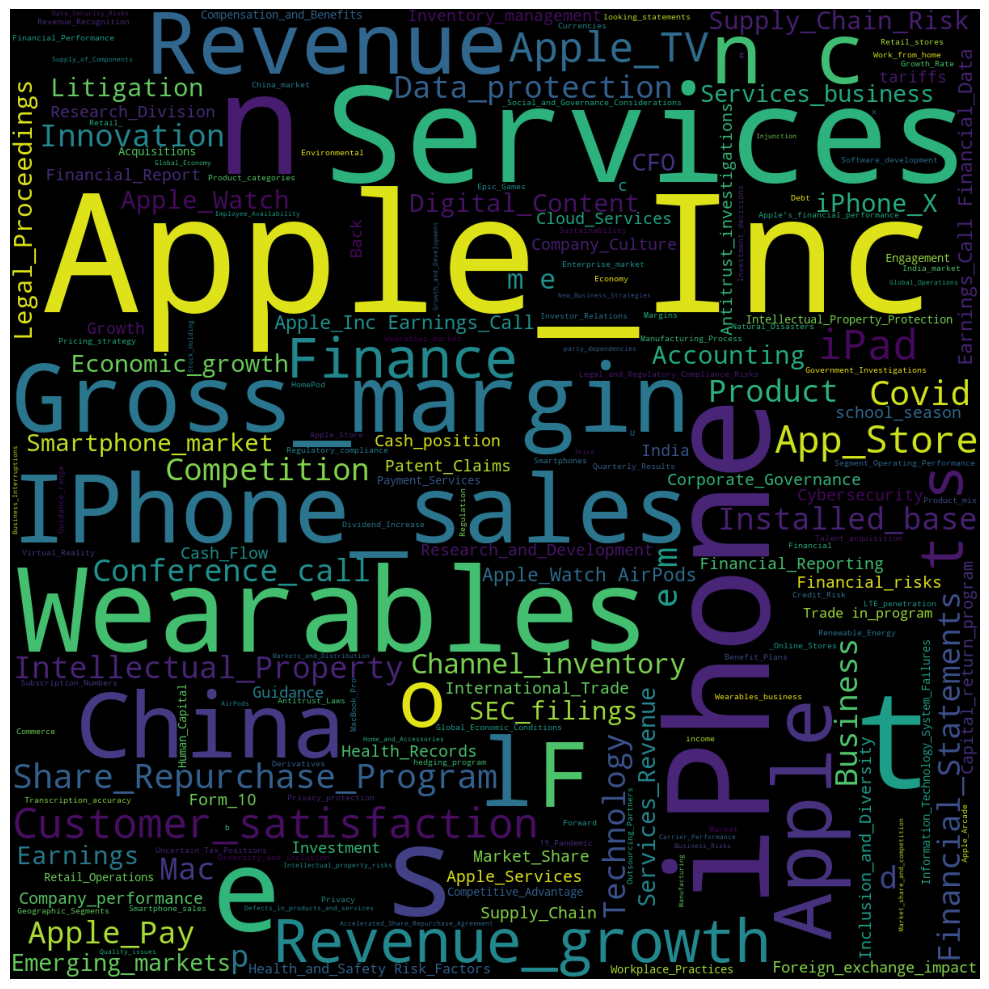

In [95]:
draw_topic_cloud(topics_df)